In [1]:
import findspark
findspark.init()
import pyspark as ps
import warnings
from pyspark.sql import SQLContext
from pymongo import MongoClient
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics 
import time
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np

In [2]:
try:
    # create SparkContext on all CPUs available
    # Tells how to acces a cluster
    sc = ps.SparkContext()
    sqlContext = SQLContext(sc)
    print("Just created a SparkContext")
except ValueError:
    warnings.warn("SparkContext already exists in this scope")

Just created a SparkContext


In [3]:
 spark = SparkSession.builder.getOrCreate()

In [4]:
# Database
client = MongoClient("localhost:27017")

# Collection name
db = client["hotel-reviews-database"]

In [5]:
resultMongo = db.clean_reviews.find()
source = list(resultMongo)
resultDf = pd.DataFrame(source)

# Reindex dataframe
resultDf.reset_index(drop=True)

resultDf = resultDf.drop(columns="_id")
resultDf.info()

# Transform dataframe into a spark dataframe
dfSpark = spark.createDataFrame(resultDf)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121757 entries, 0 to 121756
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Hotel_Name      121757 non-null  object 
 1   Reviewer_Score  121757 non-null  float64
 2   Review          121757 non-null  object 
 3   label           121757 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 3.7+ MB


In [6]:
dfSpark.dtypes

[('Hotel_Name', 'string'),
 ('Reviewer_Score', 'double'),
 ('Review', 'string'),
 ('label', 'bigint')]

In [7]:
(train_set, test_set) = dfSpark.randomSplit([0.8, 0.2], seed=2000)

In [8]:
# Zet een review om in een array van enkelvoudige woorden
tokenizer = Tokenizer(inputCol="Review", outputCol="words")
dfSparkTokTrain = tokenizer.transform(train_set)
dfSparkTokTest = tokenizer.transform(test_set)

In [9]:
# Extraheert een woordenschat uit documentverzamelingen en genereert een CountVectorizerModel.
# vocabSize = maximaal aantal woorden
cv = CountVectorizer(vocabSize=1000, inputCol="words", outputCol='cv')

dfSparkCVTrain = cv.fit(dfSparkTokTrain)
dfSparkCVTest = cv.fit(dfSparkTokTest)

dfSparkCVTrain = dfSparkCVTrain.transform(dfSparkTokTrain)
dfSparkCVTest = dfSparkCVTest.transform(dfSparkTokTest)

In [10]:
# idf 
# minDocFreq = review moet mini maal 5 worden/tekens hebben
idf = IDF(inputCol='cv', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
idfTrain = idf.fit(dfSparkCVTrain)
idfTest = idf.fit(dfSparkCVTest)

trainIdf = idfTrain.transform(dfSparkCVTrain)
testIdf = idfTest.transform(dfSparkCVTest)

In [11]:
# logRegression
# featureCol = x 
# labelCol = y
logRegression = LogisticRegression(featuresCol="features", labelCol="label")

In [12]:
%%time
logModel = logRegression.fit(trainIdf)

Wall time: 13.1 s


In [13]:
%%time
predictions = logModel.transform(testIdf)

Wall time: 71.8 ms


In [14]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)
# ROC AUC and Accuracy
roc_auc = evaluator.evaluate(predictions)
print(roc_auc)

0.7908680229428257


In [15]:
from sklearn import metrics

predictions_df = predictions.select("*").toPandas()

In [16]:
accuracy = metrics.accuracy_score(predictions_df['label'], predictions_df['prediction'])
recall = metrics.recall_score(predictions_df['label'], predictions_df['prediction'])
precision = metrics.precision_score(predictions_df['label'], predictions_df['prediction'])
f1_score = 2 * (precision * recall) / (precision + recall)

cm = metrics.confusion_matrix(predictions_df['label'], predictions_df['prediction'])

print(f"Accuracy: {accuracy} | Precision: {precision} | Recall: {recall}")
print(f"F1 score: {f1_score}")

Accuracy: 0.7304059855267999 | Precision: 0.736723612766521 | Recall: 0.8095168800931315
F1 score: 0.7714067808361644


In [17]:
print(cm)

[[ 6739  3976]
 [ 2618 11126]]


In [18]:
y_test = np.array(testIdf.select('label').collect())

In [19]:
predictionsRocCurve = np.array(predictions.select('prediction').collect())

In [20]:
fpr, tpr, _ = roc_curve(y_test, predictionsRocCurve)

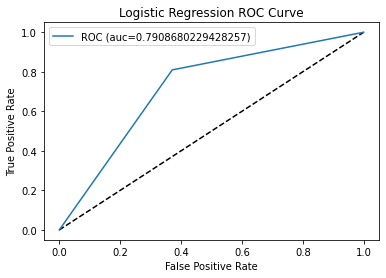

In [21]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC (auc=' + str(roc_auc) + ')')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend()
plt.show()

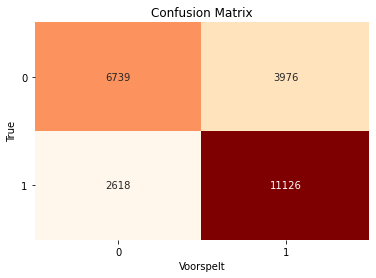

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

classes = [0, 1]
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.OrRd, cbar=False)
ax.set(xlabel="Voorspelt",
ylabel="True",
xticklabels=classes,
yticklabels=classes,
title="Confusion Matrix")
plt.yticks(rotation=0)
plt.show()